<a href="https://colab.research.google.com/github/bahmanravaei/Ising-oneDimensionalSequential/blob/main/Simulated_DA_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Simple and Sequential Python Code for Ising Model

## Import some module

In [54]:
%matplotlib inline
from math import pi
import numpy as np
import matplotlib.pyplot as plt
# change some of the defaults for plots
plt.rcParams['text.usetex'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.figsize'] = [6,6]
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
from IPython.display import display, Markdown, Latex, Math, Pretty
from timeit import timeit
from numpy.random import rand, randint, seed


## Set the Configuration Parameter

In [55]:

L = 1024           # Number of State variables
Lsqrt=32

L=400              # Number of State variables  (reduce Number of state to run quickly)
Lsqrt=20
#L = 200

#kB = 1.0         # Boltzman constant

#seed(10)
# help( randint )

T = 1.0           # temperature
n = 10000         # the number of Monte Carlo time steps
P = 100           # sorta like 1000 milliseconds in a second

## Initialize bias term

Randomly initialize bias term

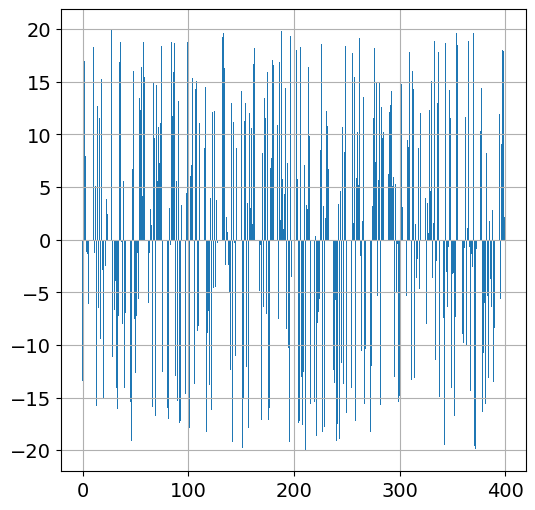

In [56]:
from numpy.ma.core import zeros

def initB(L):
  B=randint(minB, maxB, size=L)
  return B/10.0

minB=-200
maxB=200
B=initB(L)
plt.bar(range(L),B)
plt.show()

## Initialize connection weight

Randomly initialize connection weight

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]


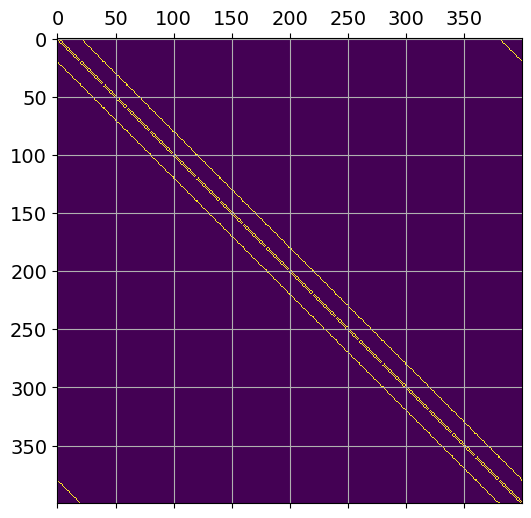

In [85]:

def initWV2(minW, maxW,L):  #set the weight randomly between minW/10 to maxW/10 (Consider a mesh structure, But we can Consider other structure and change the weight)
  W=np.zeros((L,L))
  #W=randint(minW, maxW, size=(L,L))
  for i in range(Lsqrt):
    for j in range(Lsqrt):
      #W[i*Lsqrt+j][((i-1)%Lsqrt)*Lsqrt+(j)]=randint(minW, maxW)
      W[i*Lsqrt+j][((i+1)%Lsqrt)*Lsqrt+(j)]=randint(minW, maxW)
      W[((i+1)%Lsqrt)*Lsqrt+(j)][i*Lsqrt+j]=W[i*Lsqrt+j][((i+1)%Lsqrt)*Lsqrt+(j)]
      #W[i*Lsqrt+j][(i)*Lsqrt+((j-1)%Lsqrt)]=randint(minW, maxW)
      W[i*Lsqrt+j][(i)*Lsqrt+((j+1)%Lsqrt)]=randint(minW, maxW)
      W[(i)*Lsqrt+((j+1)%Lsqrt)][i*Lsqrt+j]=W[i*Lsqrt+j][(i)*Lsqrt+((j+1)%Lsqrt)]


  return W/10.0

def initW(L):    #set all the weight to 1 (Consider a mesh structure, But we can Consider other structure and change the weight)
  W=np.zeros((L,L))
  #W=randint(minW, maxW, size=(L,L))
  for i in range(Lsqrt):
    for j in range(Lsqrt):
      W[i*Lsqrt+j][((i-1)%Lsqrt)*Lsqrt+(j)]=1
      W[i*Lsqrt+j][((i+1)%Lsqrt)*Lsqrt+(j)]=1
      W[i*Lsqrt+j][(i)*Lsqrt+((j-1)%Lsqrt)]=1
      W[i*Lsqrt+j][(i)*Lsqrt+((j+1)%Lsqrt)]=1

  return W




minW=-200
maxW=200
#W = initWV2(minW, maxW, L)

W = initW(L)

plt.matshow(W)
print(W)

## Create vector of state varialble

In [86]:
def createVector( L ) :
    """
        Creates a vector of length of L of random spins, $X_{i} = \pm 1$.
        Value for each state is 0 and 1
    """
    return ( rand( L) < 0.5 ) * 2 - 1   #        Value for each state is -1 and 1
    #return ( rand( L) < 0.5 ) * 1        #        Value for each state is 0 and 1

In [87]:

def ShowIsingModel(S):
  b=np.reshape(S,(Lsqrt,-1))
  plt.matshow(b)

### Ilustration of state values

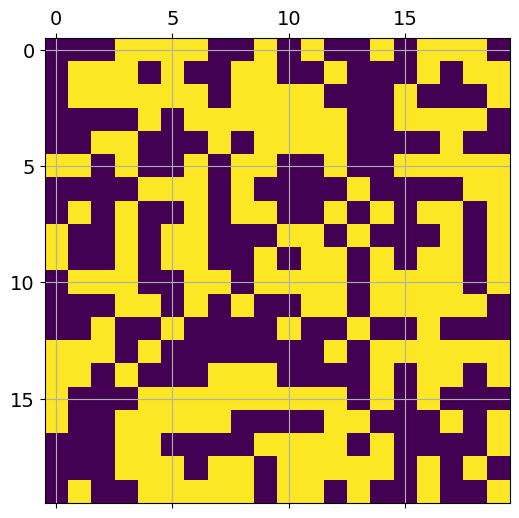

In [88]:
X = createVector( L )
ShowIsingModel(X)

## Define Function for Energy and deltaEnergy

In [89]:
def energy(W, X ) :
    Y=X.reshape(-1,L)
    newX=X.reshape(L, -1)
    E=np.sum(np.multiply(W,np.matmul(newX, Y)))
    #E = np.matmul(np.matmul(W, X.transpose()), X)
    #E= E+ np.matmul(X.transpose(), B)   # without considering B
    return - E
    #return -W * ( np.sum( s[0:L-1,:] * s[1:L,:] ) + np.sum( s[:,0:L-1] * s[:,1:L] ) )

def magnetization( X ) :
    return np.sum( X ) / L

In [90]:
row_i=W[5]
np.matmul(row_i, X.transpose())

4.0

In [91]:
def deltaEnergy(X,i):
  row_i=W[i]
  #h_i=(np.matmul(row_i, X.transpose())+B[i])    #without B
  h_i=np.matmul(row_i, X)
  #delta=-1*(1-2*X[i])*h_i
  delta=X[i]*h_i
  return delta



### Illustration of effect of fliping each bit on Energy of Ising Model

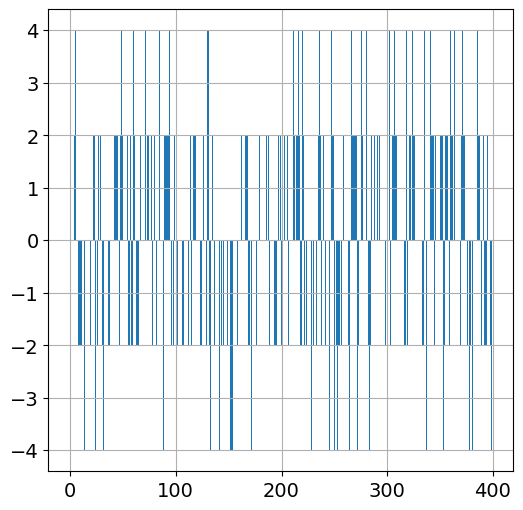

In [92]:
D=zeros(L)
for i in range(L):
  D[i]=deltaEnergy(X,i)
plt.bar(range(L),D)
plt.show()

## MCMC (metropolis method)
Must be parallel and do it for all bit Concurrently

In [96]:
def metropolis( X, oldE ) :
    # flip a random spin and calculate $dE$
    i = randint( L )
    #X[i] = 1-X[i]    # flip the i spin 0 => 1 or 1 => 0
    X[i] *= -1    # flip the i spin -1 => 1 or 1 => -1
    E = energy(W, X )
    deltaE = E - oldE
    # these are the Metropolis tests
    if deltaE < 0 :
        # keep the flipped spin because it lowers the energy
        #E = energy(W, X )
        return X, E
    deltaOverT=(- deltaE / T)
    if rand() < np.exp(deltaOverT) :
        #return 1/0
        # keep the spin flip because the random number is less than $e^{-dE/T}$
        return X, E

    # the spin flip is rejected
    #X[i] = 1-X[i]    # flip the ij spin back
    X[i] *= -1    # flip the ij spin back
    E = oldE        # and keep the old energy
    return X, E

## Define the Ising Function for calling metropolis function

In [97]:
def ising( X, n, T ) :
    """
        Runs the Metropolis algorithm $n$ times on the lattice $X_{i}$.
    """
    M = np.zeros( n )         # used to store the magnetizations, $M(t)$
    E = np.zeros( n )         # used to store the energy, $E(t)$
    E[0] = energy( W , X )
    M[0] = magnetization( X )
    percent=int(n/20)
    #print(percent)
    for t in range( 1, n ) :     # $t$ is our pseudo-time
        X, E[t] = metropolis( X, E[t-1] )
        M[t] = magnetization( X )
        #if t%percent==0:
          #print ((t/percent)*5)
          #if E[t]-E[t-percent+1]<0.000001:
           # break
    return M, E

### Calling Ising function

In [98]:


M, E = ising( X, n, T )



### Effect of N iteration of metropolis algorithm on Ising model state

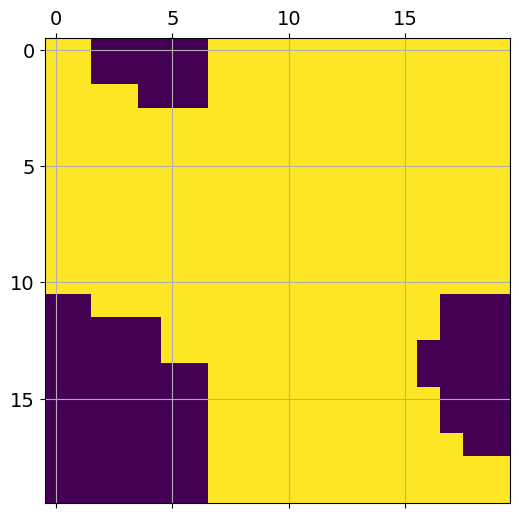

In [67]:
ShowIsingModel(X)

## Plot the energy and magnetism of model after each iteration of Metropolis algorithm

# Plot the magnetism of model

Text(0, 0.5, '$M$')

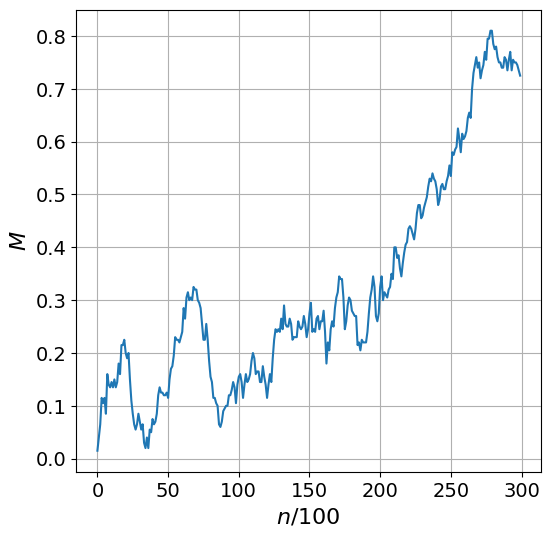

In [99]:
plt.plot( M[::P] )  # only plot every P-th point
plt.xlabel( '$n/%d$' % P )
plt.ylabel( '$M$' )

# Plot the energy of model

Text(0, 0.5, '$E$')

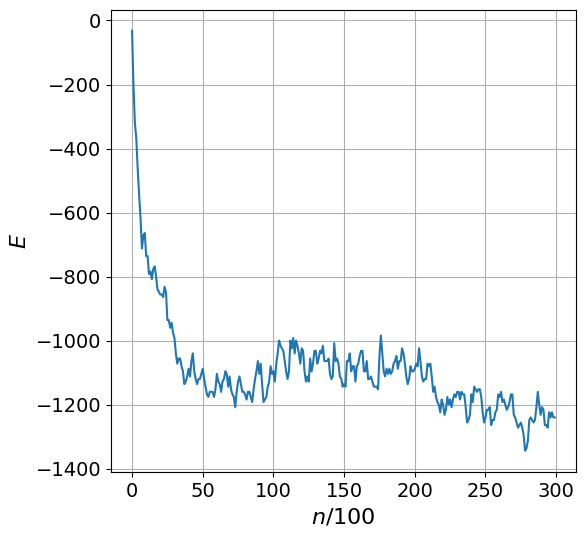

In [100]:
plt.plot( E[::P] )  # only plot every P-th point
plt.xlabel( '$n/%d$' % P )
plt.ylabel( '$E$' )

## Run the Ising model for five different Temprature scenario

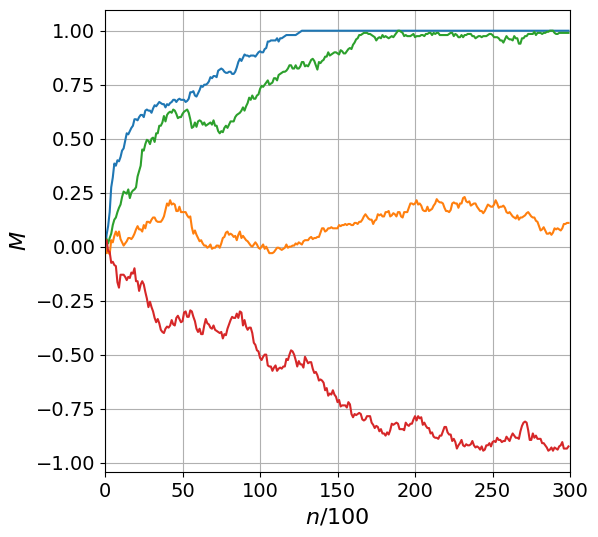

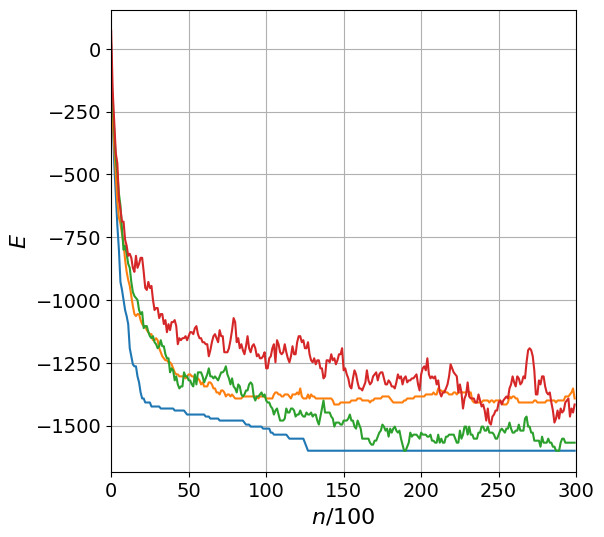

In [101]:
n = 30000               # increase the number of Monte Carlo time steps

fig, ax = plt.subplots()
ax.set_xlim( [ 0, n/P ] )
#ax.set_ylim( [-0.1, 1.1 ] )
plt.xlabel( '$n/%d$' % P )
plt.ylabel( '$M$' )

fig2, ax2 = plt.subplots()
ax2.set_xlim( [ 0, n/P ] )
plt.xlabel( '$n/%d$' % P )
plt.ylabel( '$E$' )

for T in range(1,5) :   # run the experiment 5 times
    X = createVector( L )
    M, E = ising( X, n, T )
    ax.plot( M[::P] )    # only plot every P-th point
    ax2.plot(E[::P])

#ax.plot( [0,n], [0,0] )

